<a href="https://colab.research.google.com/github/meethariprasad/phd/blob/master/Siamese_TF_Cosine_Distance_Fine_Tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%tensorflow_version 2.x
# !pip install tensorflow==2.1.0rc0
import tensorflow as tf
print (tf.__version__)
import numpy as np

2.1.0-rc1


In [5]:
x=np.asarray([-1.,-1.,-1],dtype=float)
x=np.reshape(x,(1,3))
y=np.asarray([1.,1.,1.],dtype=float)
y=np.reshape(y,(1,3))
tf.keras.layers.Dot(axes=-1,normalize=True)([x,y]).numpy()[0][0]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



-0.99999994

2.1.0-rc1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 512)          256797824   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dot (Dot)                       (None, 1)            0           keras_layer[0][0]  

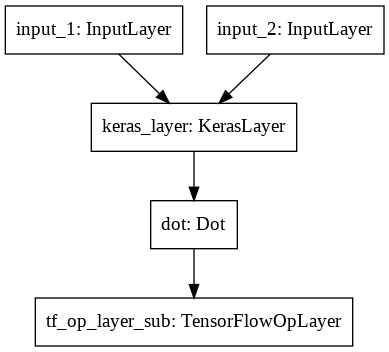

In [17]:
# !pip install tensorflow==2.1.0rc0
import tensorflow as tf
print (tf.__version__)
tf.keras.backend.clear_session()
import tensorflow_hub as hub
from tensorflow import keras
huburl="https://tfhub.dev/google/universal-sentence-encoder/4"
loaded_module_obj = hub.load(huburl)
shared_embedding_layer = hub.KerasLayer(loaded_module_obj,trainable=True)

left_input = keras.Input(shape=(), dtype=tf.string)
right_input = keras.Input(shape=(), dtype=tf.string)

embedding_left_output= shared_embedding_layer(left_input)
embedding_right_output= shared_embedding_layer(right_input)

cosine_similiarity=tf.keras.layers.Dot(axes=-1,normalize=True)([embedding_left_output,embedding_right_output])
cos_distance=1-cosine_similiarity

model = tf.keras.Model([left_input,right_input], cos_distance)
#Define Optimizer
#https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/
opz = keras.optimizers.Nadam(clipnorm=1.)
model.compile(optimizer=opz, loss='mse')
model.summary()
tf.keras.utils.plot_model(model, to_file='my_model.png')

### Cosine Distance Target Value Explanation

Cosine similiarity varies between -1 to +1, with -1 being Orthogonally Opposite and +1 being in same direction.

Cosine Distance is 1-(Cosine Similiarity)=>falls under [0,2]

Distance is Highest(Far Apart vectors) at 2, => Cosine Similiarity =-1, 1-(-1)=2

Distance is lowest(Similiar Vectors) at 0, => Cosine Similiarity = 1, 1-(1)=0

Hence if two vectors are similiar, the assignment should be 0, and if they are opposite then it must be 2

This gives us option to rank highly similiar sentences based on notion between 0 to 2.

In [11]:
import numpy as np
text_list=["Man is going to Moon","Man is going to Moon"]
left_inputs=np.asarray([text_list[0]])
right_inputs=np.asarray([text_list[1]])

similiarity=np.asarray([0])
from keras.callbacks import Callback


class stopAtLossValue(Callback):
  import numpy as np
  def on_batch_end(self, batch, logs={}):
    THR = 0 #Assign THR with the value at which you want to stop training.
    if np.round(logs.get('loss')) == THR:
      self.model.stop_training = True

import numpy as np

model.fit([left_inputs,right_inputs],similiarity,epochs=10,callbacks=[stopAtLossValue()])

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 15ms/sample - loss: 0.0000e+00


In [19]:
import tensorflow_hub as hub
import tensorflow as tf
print (text_list)

embeddings = loaded_module_obj(text_list)

# print (embeddings.numpy())

embed_target=embeddings.numpy()
import pandas as pd
doc_embed = pd.DataFrame(data=embed_target)
doc_embed.index=text_list

def get_similiarity(target_text_embed,text_to_compare_embed):
    from sklearn.metrics.pairwise import cosine_similarity
    similiarity=cosine_similarity(target_text_embed,text_to_compare_embed)
    similiarity=pd.DataFrame(similiarity)
    return similiarity



sim_a=get_similiarity(doc_embed,doc_embed)
# np.fill_diagonal(sim.values, 0)
sim_a.index=text_list
sim_a.columns=text_list
sim_a

['Man is going to Moon', 'Man is going to Moon']


,Man is going to Moon,Man is going to Moon
Man is going to Moon,1.0,1.0
Man is going to Moon,1.0,1.0


In [20]:
print ("With Fine Tune")
sim_a

With Fine Tune


,Man is going to Moon,Man is going to Moon
Man is going to Moon,1.0,1.0
Man is going to Moon,1.0,1.0


In [22]:
########################################
import tensorflow_hub as hub
import tensorflow as tf
embed = hub.load(huburl)

embeddings = embed(text_list)

print (embeddings.numpy())

embed_target=embeddings.numpy()
import pandas as pd
doc_embed_global = pd.DataFrame(data=embed_target)
doc_embed_global.index=text_list
########################################
sim_b=get_similiarity(doc_embed_global,doc_embed_global)
# np.fill_diagonal(sim.values, 0)
sim_b.index=text_list
sim_b.columns=text_list

print ("Without Fine Tune")
sim_b

[[ 0.04370566 -0.05917678 -0.05763391 ... -0.0527393   0.06156207
  -0.00462211]
 [ 0.04370566 -0.05917678 -0.05763391 ... -0.0527393   0.06156207
  -0.00462211]]
Without Fine Tune


,Man is going to Moon,Man is going to Moon
Man is going to Moon,1.0,1.0
Man is going to Moon,1.0,1.0


In [0]:
# import os
# os.makedirs('finetuned_model_export',exist_ok=True)
# export_module_dir = os.path.join(os.getcwd(), "finetuned_model_export")
# tf.saved_model.save(loaded_module_obj, export_module_dir)